The tutorial on https://www.projectpro.io/article/stock-price-prediction-using-machine-learning-project/571 was followed to figure out what libraries and function were effective in creating these models.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import io
from google.colab import files

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


In [ ]:
uploaded = files.upload()

Read in the Stock data sourced from yahoo finance. In this case we chose to do NVIDIA because it's been a fairly consistent stock with good growth and the potential to really explode in the age of AI.

In [ ]:
stock_df = pd.read_csv(io.BytesIO(uploaded['NVDA.csv']), index_col='Date')

In [ ]:
stock_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-22,0.437500,0.488281,0.388021,0.410156,0.376319,271468800
1999-01-25,0.442708,0.458333,0.410156,0.453125,0.415743,51048000
1999-01-26,0.458333,0.467448,0.411458,0.417969,0.383487,34320000
1999-01-27,0.419271,0.429688,0.395833,0.416667,0.382293,24436800
1999-01-28,0.416667,0.419271,0.412760,0.415365,0.381098,22752000


Next, we plot all the data out to get a visuallization of what this stock looks like behavior wise.

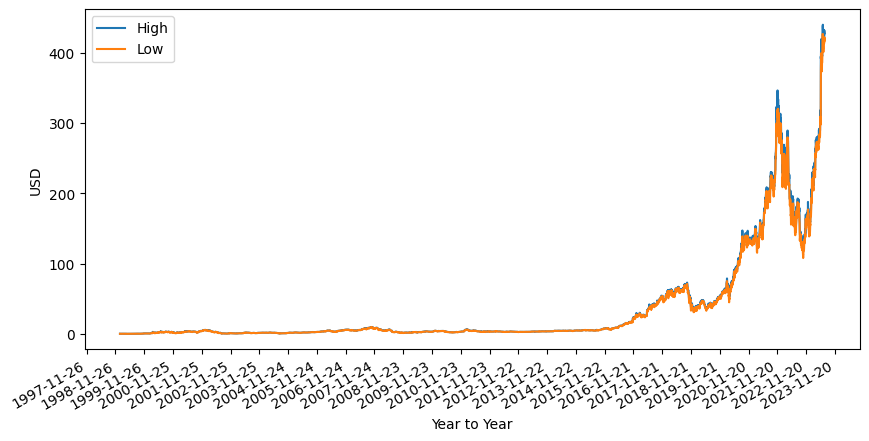

In [ ]:
plt.figure(figsize=(10,5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=365))
x_dates = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in stock_df.index.values]

plt.plot(x_dates, stock_df['High'], label='High')
plt.plot(x_dates, stock_df['Low'], label='Low')
plt.xlabel('Year to Year')
plt.ylabel('USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
stock_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-07-05,421.350006,431.769989,420.850006,423.170013,423.170013,32361800
2023-07-06,418.440002,421.790009,413.459991,421.029999,421.029999,30358200
2023-07-07,423.220001,432.140015,421.799988,425.029999,425.029999,35525300
2023-07-10,426.570007,428.109985,416.489990,421.799988,421.799988,35390800
2023-07-11,424.809998,427.579987,420.670013,424.049988,424.049988,29777500


We have to preprocess the data before feeding it into a model. We begin by seperating the data into attributes (x_data) and target (y_data). We then scale the data to make calculations easier and to avoid outliers and large numbers skewing the bias of the model.

In [ ]:
x_data = stock_df.iloc[:, 0:3]
y_data =stock_df['Close']
sc = StandardScaler()

x_fit = sc.fit_transform(x_data.values)
x_fit = pd.DataFrame(columns=x_data.columns,
                     data=x_fit,
                     index=x_data.index)
# x_fit.head()
# y_arr = y_data.values
# y_arr = np.array(y_arr)
# y_arr = y_arr.reshape(-1, 1)

# y_fit = sc.fit_transform(y_arr)

stock_fit_df = x_fit
stock_fit_df['Close'] = y_data
stock_fit_df.head()

,Open,High,Low,Close
Date,,,,
1999-01-22,-0.498255,-0.497294,-0.499170,0.410156
1999-01-25,-0.498178,-0.497728,-0.498835,0.453125
1999-01-26,-0.497946,-0.497596,-0.498816,0.417969
1999-01-27,-0.498524,-0.498144,-0.499052,0.416667
1999-01-28,-0.498563,-0.498295,-0.498796,0.415365


In [ ]:
stock_fit_df.tail()

,Open,High,Low,Close
Date,,,,
2023-07-05,5.729300,5.759728,5.848512,423.170013
2023-07-06,5.686245,5.614939,5.736946,421.029999
2023-07-07,5.756967,5.765097,5.862854,425.029999
2023-07-10,5.806531,5.706629,5.782690,421.799988
2023-07-11,5.780491,5.698940,5.845795,424.049988


We then create a function called lstm_split to create windows of size n that will take n-1 samples of data and then use those samples to predict the nth sample. The n-1 belong to the 'x' and the nth belongs to 'y'.

In [ ]:
def lstm_split(data, n_steps):
  x = []
  y = []
  for i in range(len(data) - n_steps + 1):
    x.append(data[i:i + n_steps, :-1])
    y.append(data[i + n_steps - 1, -1])

  return np.array(x), np.array(y)

Next, we split our data into the training and testing sets. We start by taking n_steps = 2 which means we use two previous days to predict the third day. x1 is 1 smaller than the original x_data because you cannot use the last two days to predict anything because we wouldnt have the third day "true" value to compare the prediction to.

In [ ]:
x1, y1 = lstm_split(stock_fit_df.values, n_steps = 2)

train_split = 0.8
split_index = int(np.ceil(len(x1) * train_split))
date_index = stock_df.index

x_train, x_test = x1[:split_index], x1[split_index:]
y_train, y_test = y1[:split_index], y1[split_index:]
x_train_date, x_test_date = date_index[:split_index], date_index[split_index:]

print(x_data.shape)
print(x1.shape, x_train.shape, x_test.shape, y_test.shape)
# print(x_train[1])
print(x_train[2])

(6156, 3)
(6155, 2, 3) (4924, 2, 3) (1231, 2, 3) (1231,)
[[-0.49794643 -0.49759622 -0.4988157 ]
 [-0.49852437 -0.49814404 -0.49905159]]


In [ ]:
print(x1[-2])

[[5.75696685 5.7650965  5.86285423]
 [5.80653141 5.70662895 5.7826896 ]]


In [ ]:
# print(x1[0], x1[1], x1[2])
# print()
print(y_train)
stock_fit_df.head()

[ 0.453125  0.417969  0.416667 ... 65.357498 64.769997 64.360001]


,Open,High,Low,Close
Date,,,,
1999-01-22,-0.498255,-0.497294,-0.499170,0.410156
1999-01-25,-0.498178,-0.497728,-0.498835,0.453125
1999-01-26,-0.497946,-0.497596,-0.498816,0.417969
1999-01-27,-0.498524,-0.498144,-0.499052,0.416667
1999-01-28,-0.498563,-0.498295,-0.498796,0.415365


Create the lstm object and add a single dense layer to it. We're simply creating the shape of the network, but not fitting it to our data yet.The input shape is based on feeding the network day highs x_train

In [ ]:
lstm = Sequential()
lstm.add(LSTM(32,
              input_shape=(x_train.shape[1], x_train.shape[2]),
              activation='relu',
              return_sequences=True))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error',
             optimizer='adam')
lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 2, 32)             4608      
                                                                 
 dense_3 (Dense)             (None, 2, 1)              33        
                                                                 
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


We then fit our data to the network, with inputs from the x training set and outputs from the y training set. We run the model for 100 epochs

In [ ]:
history = lstm.fit(x_train,
                   y_train,
                   epochs=100,
                   batch_size=4,
                   verbose=2,
                   shuffle=False)

Epoch 1/100
1231/1231 - 5s - loss: 103.0716 - 5s/epoch - 4ms/step
Epoch 2/100
1231/1231 - 2s - loss: 331.5984 - 2s/epoch - 2ms/step
Epoch 3/100
1231/1231 - 2s - loss: 76.2474 - 2s/epoch - 2ms/step
Epoch 4/100
1231/1231 - 2s - loss: 70.2237 - 2s/epoch - 2ms/step
Epoch 5/100
1231/1231 - 3s - loss: 46.7450 - 3s/epoch - 2ms/step
Epoch 6/100
1231/1231 - 3s - loss: 20.7325 - 3s/epoch - 2ms/step
Epoch 7/100
1231/1231 - 2s - loss: 5.2494 - 2s/epoch - 2ms/step
Epoch 8/100
1231/1231 - 3s - loss: 1.7327 - 3s/epoch - 2ms/step
Epoch 9/100
1231/1231 - 2s - loss: 0.9702 - 2s/epoch - 2ms/step
Epoch 10/100
1231/1231 - 3s - loss: 0.6573 - 3s/epoch - 3ms/step
Epoch 11/100
1231/1231 - 3s - loss: 0.5140 - 3s/epoch - 2ms/step
Epoch 12/100
1231/1231 - 3s - loss: 0.4362 - 3s/epoch - 2ms/step
Epoch 13/100
1231/1231 - 3s - loss: 0.3939 - 3s/epoch - 2ms/step
Epoch 14/100
1231/1231 - 3s - loss: 0.3613 - 3s/epoch - 2ms/step
Epoch 15/100
1231/1231 - 3s - loss: 0.3285 - 3s/epoch - 3ms/step
Epoch 16/100
1231/1231 - 3

We check the history object created from fitting the model.

In [ ]:
print(history.params)
print(history.history.keys())
print(history.history['loss'])

{'verbose': 2, 'epochs': 100, 'steps': 1231}
dict_keys(['loss'])
[103.07158660888672, 331.5983581542969, 76.24739074707031, 70.2236557006836, 46.744964599609375, 20.7325439453125, 5.249440670013428, 1.732655644416809, 0.9702268242835999, 0.6573206782341003, 0.5139606595039368, 0.43621212244033813, 0.3939402997493744, 0.3612820506095886, 0.32854926586151123, 0.31031131744384766, 0.29968327283859253, 0.2902630865573883, 0.2807192802429199, 0.27151796221733093, 0.2645423114299774, 0.2600175440311432, 0.25634467601776123, 0.25097066164016724, 0.24624009430408478, 0.24103157222270966, 0.23742829263210297, 0.23367108404636383, 0.22845275700092316, 0.22499169409275055, 0.22159503400325775, 0.22069744765758514, 0.22023318707942963, 0.22002556920051575, 0.21946218609809875, 0.21868295967578888, 0.21791739761829376, 0.21714015305042267, 0.21618932485580444, 0.21606162190437317, 0.21536332368850708, 0.21472564339637756, 0.21397845447063446, 0.21337983012199402, 0.21280662715435028, 0.212403237819

Graphing the model shows that just after a few epochs the model quickly converged to a fractional loss.

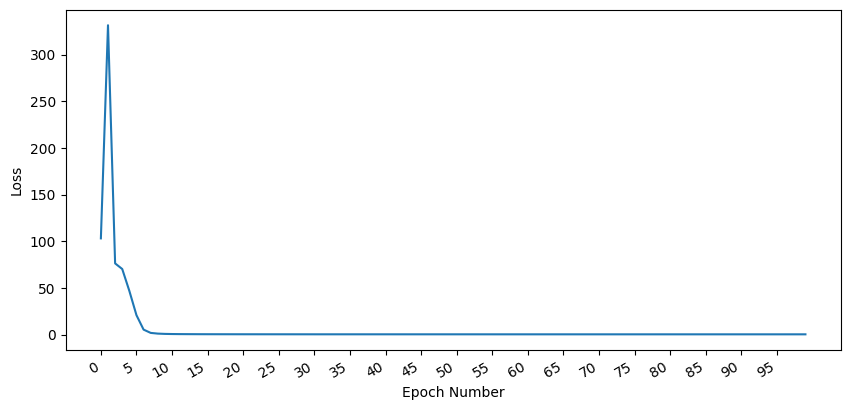

In [ ]:
plt.figure(figsize=(10,5))
epoch_loss = history.history['loss']
epoch_num = range(0, 100, 1)
plt.plot(epoch_num, epoch_loss)

plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.xticks(range(0, 100, 5))
plt.gcf().autofmt_xdate()
plt.show()

We graphed the data again, but this time excluding the first 10 epochs to get a better idea of how, and when the converge levelled out.

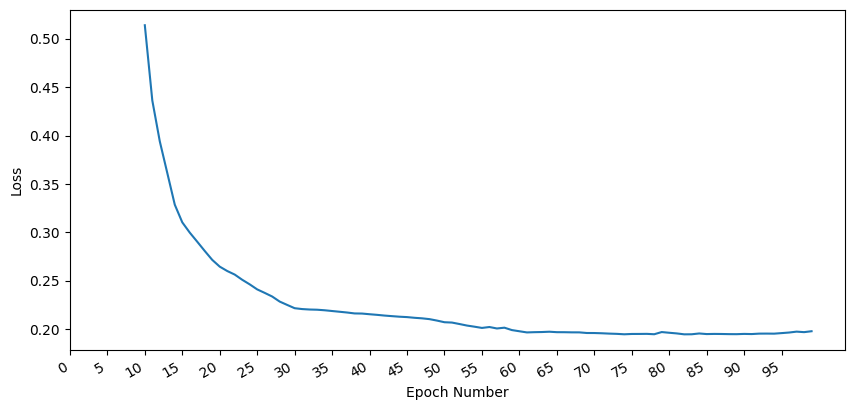

In [ ]:
plt.figure(figsize=(10,5))
epoch_loss = history.history['loss'][10:]
epoch_num = range(10, 100, 1)
plt.plot(epoch_num, epoch_loss)

plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.xticks(range(0, 100, 5))
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
y_pred = lstm.predict(x_test)
print(x_test.shape, y_pred.shape)
y_pred = [pred[1] for pred in [item for item in y_pred]]

39/39 [==============================] - 0s 2ms/step
(1231, 2, 3) (1231, 2, 1)


Issue with return dimensionality, instead saving the the second returned y prediction series as the only series

In [ ]:
print(y_pred[1])

[62.632298]


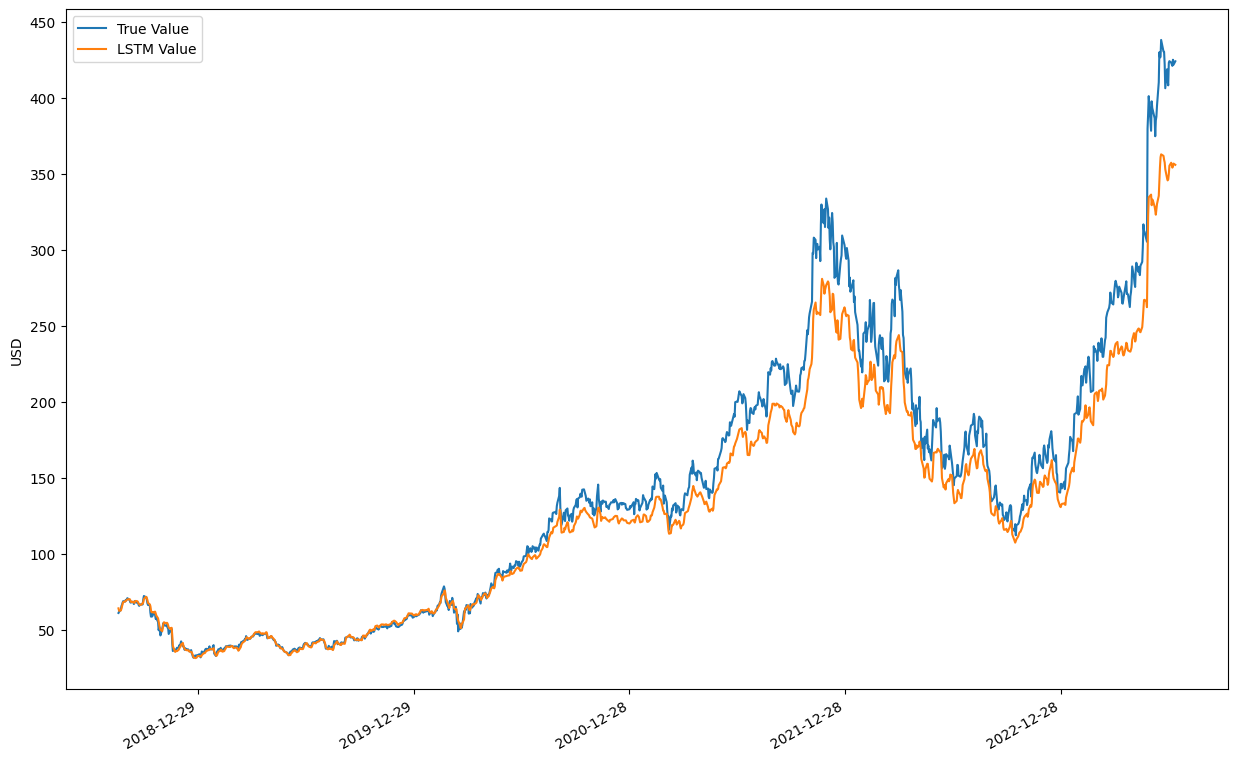

In [ ]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=365))
x_dates = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in x_test_date]

plt.plot(x_dates[:-1], y_test, label='True Value')
plt.plot(x_dates[:-1], y_pred, label='LSTM Value')
plt.ylabel('USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
print('RSME: ' + str(rmse))
print('MAPE: ' + str(mape))

RSME: 21.068226018046328
MAPE: 0.073225448502312


In [ ]:
y_arr = y_test.reshape(-1, 1)
y_test_fit = sc.fit_transform(y_arr)

y_pred_fit = sc.fit_transform(y_pred)

rmse = mean_squared_error(y_test_fit, y_pred_fit, squared=False)
mape = mean_absolute_percentage_error(y_test_fit, y_pred_fit)
print('RSME: ' + str(rmse))
print('MAPE: ' + str(mape))

RSME: 0.05638482719478797
MAPE: 0.23729406648355994


Netx, we attempt to tune the number of layers and how large they are to see if that improves the model.

In [ ]:
lstm2 = Sequential()
lstm2.add(LSTM(50,
              input_shape=(x_train.shape[1], x_train.shape[2]),
              activation='relu',
              return_sequences=True))
lstm2.add(LSTM(50, activation='relu'))

lstm2.add(Dense(1))
lstm2.compile(loss='mean_squared_error',
             optimizer='adam')
lstm2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 2, 50)             10800     
                                                                 
 lstm_6 (LSTM)               (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 31,051
Trainable params: 31,051
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history2 = lstm2.fit(x_train,
                   y_train,
                   epochs=100,
                   batch_size=4,
                   verbose=2,
                   shuffle=False)

Epoch 1/100
1231/1231 - 6s - loss: 12.4422 - 6s/epoch - 5ms/step
Epoch 2/100
1231/1231 - 4s - loss: 149.2006 - 4s/epoch - 4ms/step
Epoch 3/100
1231/1231 - 4s - loss: 8.8482 - 4s/epoch - 3ms/step
Epoch 4/100
1231/1231 - 4s - loss: 2.9058 - 4s/epoch - 3ms/step
Epoch 5/100
1231/1231 - 5s - loss: 1.5917 - 5s/epoch - 4ms/step
Epoch 6/100
1231/1231 - 4s - loss: 1.2285 - 4s/epoch - 3ms/step
Epoch 7/100
1231/1231 - 4s - loss: 1.1866 - 4s/epoch - 3ms/step
Epoch 8/100
1231/1231 - 5s - loss: 1.0880 - 5s/epoch - 4ms/step
Epoch 9/100
1231/1231 - 3s - loss: 0.9042 - 3s/epoch - 3ms/step
Epoch 10/100
1231/1231 - 4s - loss: 1.4639 - 4s/epoch - 3ms/step
Epoch 11/100
1231/1231 - 4s - loss: 1.5218 - 4s/epoch - 3ms/step
Epoch 12/100
1231/1231 - 4s - loss: 1.5463 - 4s/epoch - 3ms/step
Epoch 13/100
1231/1231 - 4s - loss: 1.5532 - 4s/epoch - 3ms/step
Epoch 14/100
1231/1231 - 4s - loss: 1.5144 - 4s/epoch - 3ms/step
Epoch 15/100
1231/1231 - 5s - loss: 1.4869 - 5s/epoch - 4ms/step
Epoch 16/100
1231/1231 - 4s - l

In [ ]:
print(history2.params)
print(history2.history.keys())
print(history2.history['loss'])

{'verbose': 2, 'epochs': 100, 'steps': 1231}
dict_keys(['loss'])
[12.442158699035645, 149.20059204101562, 8.848190307617188, 2.9058079719543457, 1.5917270183563232, 1.2284600734710693, 1.186629295349121, 1.0879818201065063, 0.9041998982429504, 1.463882327079773, 1.5217753648757935, 1.5462638139724731, 1.5531502962112427, 1.5143985748291016, 1.4868803024291992, 1.3896268606185913, 1.3023943901062012, 1.2023508548736572, 1.0817012786865234, 0.9812783002853394, 0.8809609413146973, 0.7785167098045349, 0.7199115753173828, 0.6626064777374268, 0.5962045192718506, 0.49028509855270386, 0.4453228712081909, 0.4129156172275543, 0.39575430750846863, 0.38267987966537476, 0.37181413173675537, 0.3676271438598633, 0.3654283285140991, 0.3631650507450104, 0.36042946577072144, 0.3574846088886261, 0.3550814688205719, 0.3499302864074707, 0.34660887718200684, 0.3432309329509735, 0.34176814556121826, 0.3386078476905823, 0.33716556429862976, 0.3332408368587494, 0.3298628330230713, 0.32509011030197144, 0.323570

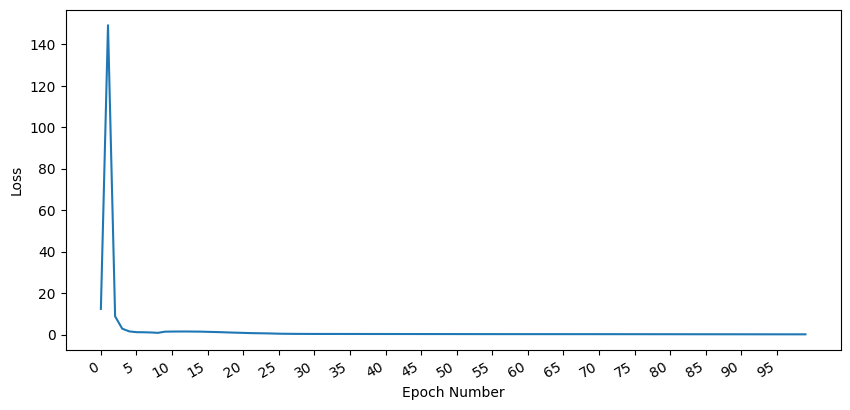

In [ ]:
plt.figure(figsize=(10,5))
epoch_loss = history2.history['loss']
epoch_num = range(0, 100, 1)
plt.plot(epoch_num, epoch_loss)

plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.xticks(range(0, 100, 5))
plt.gcf().autofmt_xdate()
plt.show()

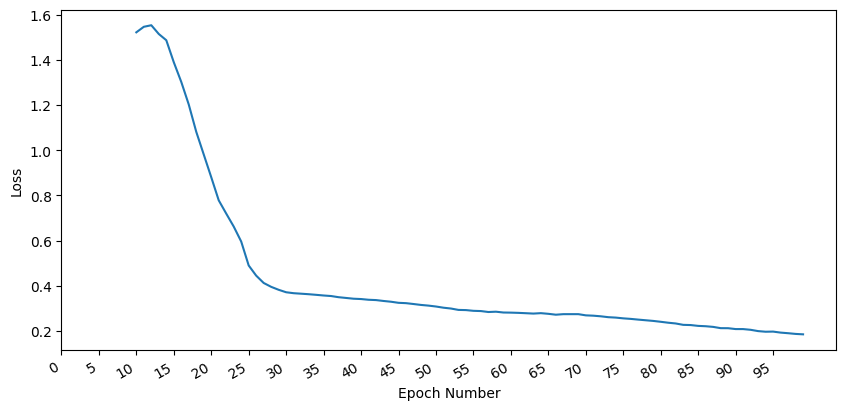

In [ ]:
plt.figure(figsize=(10,5))
epoch_loss = history2.history['loss'][10:]
epoch_num = range(10, 100, 1)
plt.plot(epoch_num, epoch_loss)

plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.xticks(range(0, 100, 5))
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
y_pred2 = lstm2.predict(x_test)

39/39 [==============================] - 0s 2ms/step


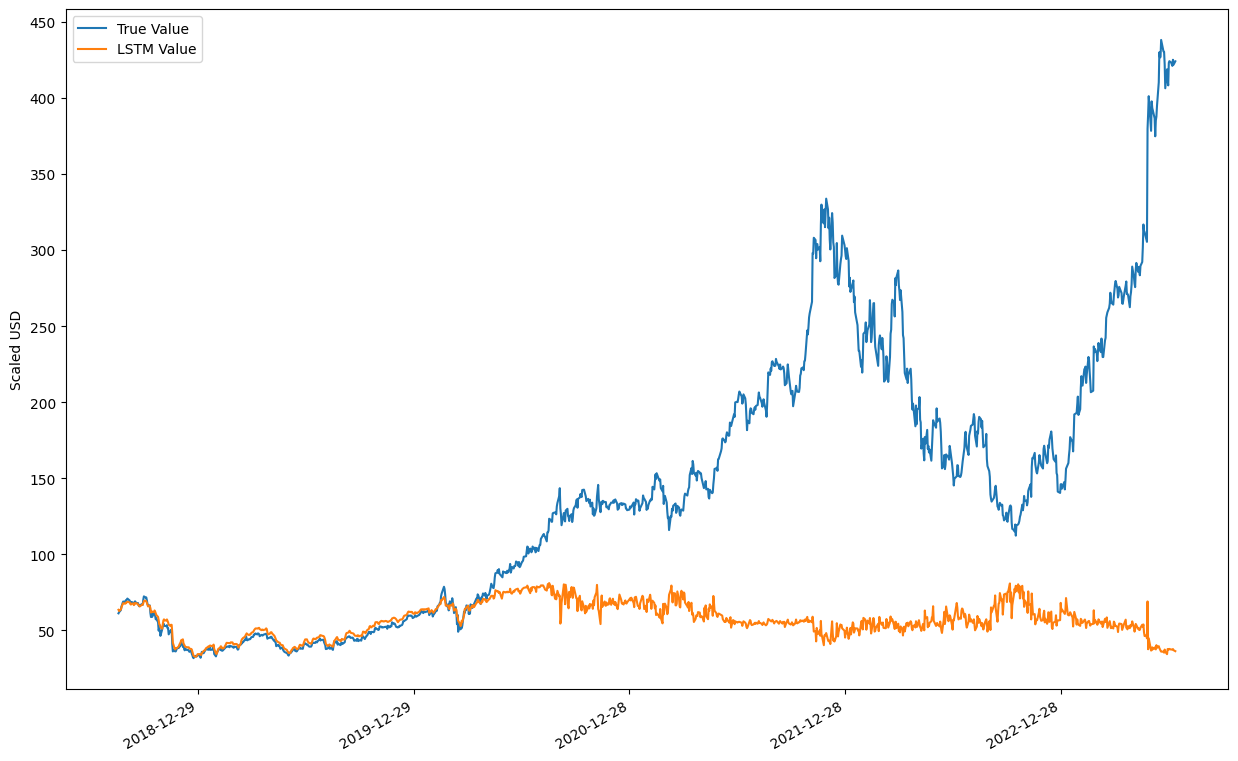

In [ ]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=365))
x_dates = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in x_test_date]

plt.plot(x_dates[:-1], y_test, label='True Value')
plt.plot(x_dates[:-1], y_pred2, label='LSTM Value')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
rmse = mean_squared_error(y_test, y_pred2, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred2)
print('RSME: ' + str(rmse))
print('MAPE: ' + str(mape))

RSME: 123.80050629566476
MAPE: 0.42011145008765954


In [ ]:
y_pred2_fit = sc.fit_transform(y_pred2)

rmse = mean_squared_error(y_test_fit, y_pred2_fit, squared=False)
mape = mean_absolute_percentage_error(y_test_fit, y_pred2_fit)
print('RSME: ' + str(rmse))
print('MAPE: ' + str(mape))

RSME: 1.483633080197047
MAPE: 5.022235075172936


The model did significantly worse, which looks like the result of overfitting on the training data which had far less movement than the testing set. We will again create a new model, but this time we will only increase the number of steps to split.

In [ ]:
x1, y1 = lstm_split(stock_fit_df.values, n_steps = 3)

train_split = 0.8
split_index = int(np.ceil(len(x1) * train_split))
date_index = stock_df.index

x_train, x_test = x1[:split_index], x1[split_index:]
y_train, y_test = y1[:split_index], y1[split_index:]
x_train_date, x_test_date = date_index[:split_index], date_index[split_index:]

In [ ]:
lstm3 = Sequential()
lstm3.add(LSTM(20,
              input_shape=(x_train.shape[1], x_train.shape[2]),
              activation='relu',
              return_sequences=True))

lstm3.add(Dense(1))
lstm3.compile(loss='mean_squared_error',
             optimizer='adam')
lstm3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 3, 20)             1920      
                                                                 
 dense_5 (Dense)             (None, 3, 1)              21        
                                                                 
Total params: 1,941
Trainable params: 1,941
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history3 = lstm3.fit(x_train,
                   y_train,
                   epochs=20,
                   batch_size=4,
                   verbose=2,
                   shuffle=False)

Epoch 1/20
1231/1231 - 5s - loss: 115.6236 - 5s/epoch - 4ms/step
Epoch 2/20
1231/1231 - 3s - loss: 281.3719 - 3s/epoch - 2ms/step
Epoch 3/20
1231/1231 - 3s - loss: 82.4343 - 3s/epoch - 2ms/step
Epoch 4/20
1231/1231 - 3s - loss: 50.7717 - 3s/epoch - 2ms/step
Epoch 5/20
1231/1231 - 4s - loss: 38.0933 - 4s/epoch - 3ms/step
Epoch 6/20
1231/1231 - 3s - loss: 28.6726 - 3s/epoch - 2ms/step
Epoch 7/20
1231/1231 - 3s - loss: 16.4858 - 3s/epoch - 2ms/step
Epoch 8/20
1231/1231 - 3s - loss: 6.3705 - 3s/epoch - 2ms/step
Epoch 9/20
1231/1231 - 4s - loss: 1.8885 - 4s/epoch - 3ms/step
Epoch 10/20
1231/1231 - 3s - loss: 0.8616 - 3s/epoch - 2ms/step
Epoch 11/20
1231/1231 - 3s - loss: 0.6098 - 3s/epoch - 2ms/step
Epoch 12/20
1231/1231 - 3s - loss: 0.5341 - 3s/epoch - 2ms/step
Epoch 13/20
1231/1231 - 3s - loss: 0.4826 - 3s/epoch - 3ms/step
Epoch 14/20
1231/1231 - 3s - loss: 0.4310 - 3s/epoch - 2ms/step
Epoch 15/20
1231/1231 - 3s - loss: 0.3953 - 3s/epoch - 2ms/step
Epoch 16/20
1231/1231 - 3s - loss: 0.366

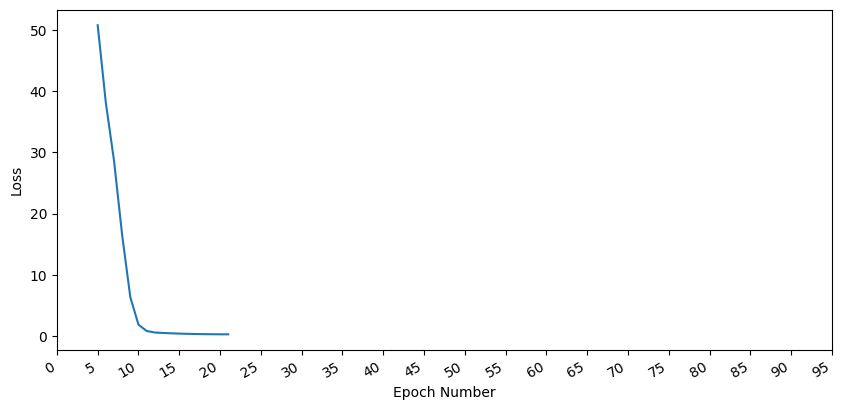

In [ ]:
plt.figure(figsize=(10,5))
epoch_loss = history3.history['loss'][3:]
epoch_num = range(5, 22, 1)
plt.plot(epoch_num, epoch_loss)

plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.xticks(range(0, 100, 5))
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
y_pred3 = lstm3.predict(x_test)
y_pred3 = [pred[2] for pred in [item for item in y_pred3]]

39/39 [==============================] - 0s 2ms/step


In [ ]:
x_test

array([[[0.46399887, 0.4458941 , 0.45743908],
        [0.4308573 , 0.41314236, 0.41486576],
        [0.39475656, 0.41397655, 0.39595688]],

       [[0.4308573 , 0.41314236, 0.41486576],
        [0.39475656, 0.41397655, 0.39595688],
        [0.41443443, 0.41506467, 0.42984945]],

       [[0.39475656, 0.41397655, 0.39595688],
        [0.41443443, 0.41506467, 0.42984945],
        [0.42738037, 0.44959359, 0.44555027]],

       ...,

       [[5.72929959, 5.75972817, 5.84851242],
        [5.68624502, 5.61493892, 5.73694594],
        [5.75696685, 5.7650965 , 5.86285423]],

       [[5.68624502, 5.61493892, 5.73694594],
        [5.75696685, 5.7650965 , 5.86285423],
        [5.80653141, 5.70662895, 5.7826896 ]],

       [[5.75696685, 5.7650965 , 5.86285423],
        [5.80653141, 5.70662895, 5.7826896 ],
        [5.78049144, 5.69893975, 5.84579508]]])

In [ ]:
print(len(x_test_date))
print(len(y_test))

1232
1230


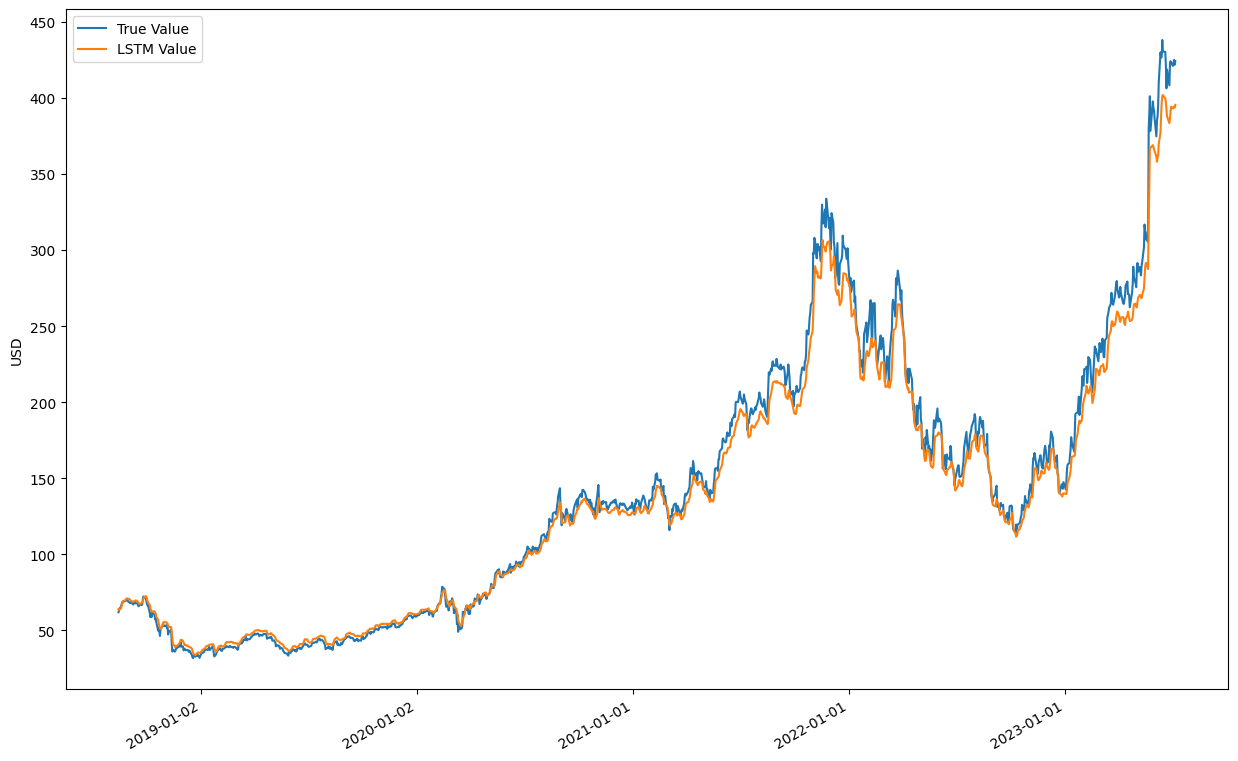

In [ ]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=365))
x_dates = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in x_test_date]

plt.plot(x_dates[:-2], y_test, label='True Value')
plt.plot(x_dates[:-2], y_pred3, label='LSTM Value')

plt.ylabel('USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
rmse = mean_squared_error(y_test, y_pred3, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred3)
print('RSME: ' + str(rmse))
print('MAPE: ' + str(mape))

RSME: 10.584467218612232
MAPE: 0.04782307354196434


In [ ]:
y_arr = y_test.reshape(-1, 1)
y_test_fit = sc.fit_transform(y_arr)
y_pred3_fit = sc.fit_transform(y_pred3)

rmse = mean_squared_error(y_test_fit, y_pred3_fit, squared=False)
mape = mean_absolute_percentage_error(y_test_fit, y_pred3_fit)
print('RSME: ' + str(rmse))
print('MAPE: ' + str(mape))

RSME: 0.05475516247256269
MAPE: 0.24951409981899256


In [ ]:
x_train.shape


(4924, 3, 3)

We can see that with 3 steps, the model appear to improve accuracy significantly.

Now what if we only had prices for the once a week, how well does that seem to fit

In [ ]:
future = x_test[-2:]
future = future[0]
print(future.shape)
print(future)
# print(x_test[-1])
y_pred4 = lstm3.predict(np.array([future]))

(3, 3)
[[5.68624502 5.61493892 5.73694594]
 [5.75696685 5.7650965  5.86285423]
 [5.80653141 5.70662895 5.7826896 ]]
1/1 [==============================] - 0s 22ms/step


In [ ]:
print(y_pred4[0][-1])

[393.67908]


In [ ]:
x_test_date[-6]

'2023-07-03'

In [ ]:
stock_fit_df.tail()

,Open,High,Low,Close
Date,,,,
2023-07-05,5.729300,5.759728,5.848512,423.170013
2023-07-06,5.686245,5.614939,5.736946,421.029999
2023-07-07,5.756967,5.765097,5.862854,425.029999
2023-07-10,5.806531,5.706629,5.782690,421.799988
2023-07-11,5.780491,5.698940,5.845795,424.049988


In [ ]:
stock_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-07-05,421.350006,431.769989,420.850006,423.170013,423.170013,32361800
2023-07-06,418.440002,421.790009,413.459991,421.029999,421.029999,30358200
2023-07-07,423.220001,432.140015,421.799988,425.029999,425.029999,35525300
2023-07-10,426.570007,428.109985,416.489990,421.799988,421.799988,35390800
2023-07-11,424.809998,427.579987,420.670013,424.049988,424.049988,29777500
